## Imports

In [1]:
import torch
from torch import nn

from st_nca.common import resume, get_device, checkpoint_all
from st_nca.datasets.PEMS import PEMS03, PEMS04, PEMS08, get_config as pems_get_config
from st_nca.cellmodel import CellModel, load_config, get_config, save_as, setup
from st_nca.pretrain import training_loop
from st_nca.gca import GraphCellularAutomata, timestamp_generator, save as gca_save, setup as gca_setup
from st_nca.finetune import FineTunningDataset, finetune_loop
from st_nca.evaluate import evaluate, diff_states

## General Codes

In [2]:
DATASET = 8
DEVICE = get_device()
DTYPE = torch.float32
DEFAULT_PATH = 'C:\\Users\\petro\\Dropbox\\Projetos\\futurelab\\posdoc\\st_nca\\st_nca\\st_nca\\'
#DEFAULT_PATH = 'D:\\Dropbox\\Projetos\\futurelab\\posdoc\\st_nca\\st_nca\\st_nca\\'
DATA_PATH = DEFAULT_PATH + 'data\\PEMS0{}\\'.format(DATASET)
MODELS_PATH = DEFAULT_PATH + 'weights\\PEMS0{}\\'.format(DATASET)


## 1 Step Ahead (5 Minutes / 12 NGCA iterations)

In [8]:
CM_FILE = MODELS_PATH + 'cm3x16x1024_3x1024_h1_smape20.pt'
GCA_FILE = MODELS_PATH + 'gca3x16x1024_h1.pt'

STEPS_AHEAD = 1

pems = PEMS08(edges_file = DATA_PATH + 'edges.csv', data_file = DATA_PATH + 'data.csv',
    device = DEVICE, dtype = DTYPE, steps_ahead = STEPS_AHEAD)

In [4]:
config = {
    'num_tokens': pems.max_length,
    'dim_token': pems.token_dim,
    'num_transformers': 3,
    'num_heads': 16,
    'transformer_feed_forward': 1024,
    'transformer_activation': nn.GELU(approximate='none'),
    'normalization': torch.nn.modules.normalization.LayerNorm,
    'pre_norm': False,
    'feed_forward': 3,
    'feed_forward_dim': 1024,
    'feed_forward_activation': nn.GELU(approximate='none'),
    'device': DEVICE,
    'dtype': DTYPE,
    'steps_ahead': STEPS_AHEAD
 }

FLAUTIM_FILE = MODELS_PATH + 'OlwLedGbWh2XBP3yn_8iG_weights.h5'


save_as(FLAUTIM_FILE, CM_FILE, pems, config = config)

In [9]:
model, pems = setup(CM_FILE, pems, get_device())

{'num_heads': 16, 'normalization': <class 'torch.nn.modules.normalization.LayerNorm'>, 'pre_norm': False, 'transformer_feed_forward': 1024, 'transformer_activation': GELU(approximate='none'), 'num_tokens': 10, 'dim_token': 7, 'num_transformers': 3, 'feed_forward': 3, 'feed_forward_dim': 1024, 'feed_forward_activation': GELU(approximate='none'), 'device': 'cuda', 'dtype': torch.float32, 'steps_ahead': 1, 'config': {'normalization': <class 'torch.nn.modules.normalization.LayerNorm'>, 'pre_norm': False, 'steps_ahead': 1}}


c:\Users\petro\Dropbox\Projetos\futurelab\posdoc\st_nca\st_nca\st_nca\cellmodel.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_config = torch.load(file)


### Setup NGCA and Finetune

In [10]:
gca = GraphCellularAutomata(device=model.device, dtype=model.dtype, graph = pems.G,
                            max_length = pems.max_length, token_size=pems.token_dim,
                            tokenizer=pems.tokenizer, cell_model = model)


In [ ]:
finetune_ds = FineTunningDataset(pems, increment_type='hours', increment=1, steps_ahead=1, step=250)

finetune_loop(get_device(), finetune_ds, gca, 
              iterations = 12, increment_type='minutes', increment=5,
              epochs = 150, batch = 1, lr = 0.00001,
              checkpoint_file =  GCA_FILE)

In [11]:
gca.load_state_dict(torch.load(GCA_FILE+"BEST", weights_only=True))

<All keys matched successfully>

In [22]:
gca_save(GCA_FILE, pems, gca)

### Evaluation

In [14]:
finetune_ds = FineTunningDataset(pems, increment_type='minutes', increment=5, steps_ahead=12, step=250)
df = evaluate(finetune_ds.test(), gca, 12, increment_type='minutes', increment=5)
df.describe()

,timestamp,mape,mae,rmse,nrmse
count,0,0,0,0,0
unique,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN


## 12 Steps Ahead (1 hour / 1 NGCA iteration)

In [3]:
CM_FILE = MODELS_PATH + 'cm3x16x1024_3x1024_h12_smape20.pt'
GCA_FILE = MODELS_PATH + 'gca3x16x1024_h12.pt'

STEPS_AHEAD = 12


pems = PEMS08(edges_file = DATA_PATH + 'edges.csv', data_file = DATA_PATH + 'data.csv',
    device = DEVICE, dtype = DTYPE, steps_ahead = STEPS_AHEAD)

### Import Cell Model

In [5]:
config = {
    'num_tokens': pems.max_length,
    'dim_token': pems.token_dim,
    'num_transformers': 3,
    'num_heads': 16,
    'transformer_feed_forward': 1024,
    'transformer_activation': nn.GELU(approximate='none'),
    'normalization': torch.nn.modules.normalization.LayerNorm,
    'pre_norm': False,
    'feed_forward': 3,
    'feed_forward_dim': 1024,
    'feed_forward_activation': nn.GELU(approximate='none'),
    'device': DEVICE,
    'dtype': DTYPE,
    'steps_ahead': STEPS_AHEAD
 }

FLAUTIM_FILE = MODELS_PATH + 'OlwLedGbWh2XBP3yn_8iG_weights.h5'


save_as(FLAUTIM_FILE, CM_FILE, pems, config = config)

In [4]:
model, pems = setup(CM_FILE, pems, get_device())

{'num_heads': 16, 'normalization': <class 'torch.nn.modules.normalization.LayerNorm'>, 'pre_norm': False, 'transformer_feed_forward': 1024, 'transformer_activation': GELU(approximate='none'), 'num_tokens': 10, 'dim_token': 7, 'num_transformers': 3, 'feed_forward': 3, 'feed_forward_dim': 1024, 'feed_forward_activation': GELU(approximate='none'), 'device': 'cuda', 'dtype': torch.float32, 'steps_ahead': 12, 'config': {'normalization': <class 'torch.nn.modules.normalization.LayerNorm'>, 'pre_norm': False, 'steps_ahead': 12}}


c:\Users\petro\Dropbox\Projetos\futurelab\posdoc\st_nca\st_nca\st_nca\cellmodel.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_config = torch.load(file)


### Setup NGCA and Finetune

In [5]:
gca = GraphCellularAutomata(device=model.device, dtype=model.dtype, graph = pems.G,
                            max_length = pems.max_length, token_size=pems.token_dim,
                            tokenizer=pems.tokenizer, cell_model = model)


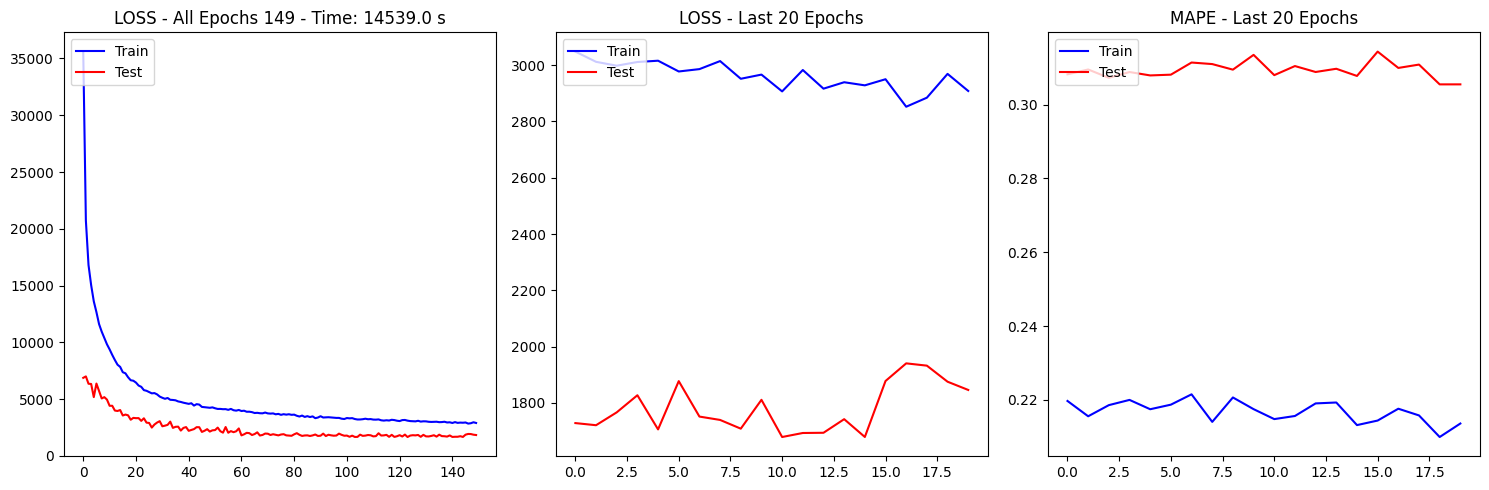

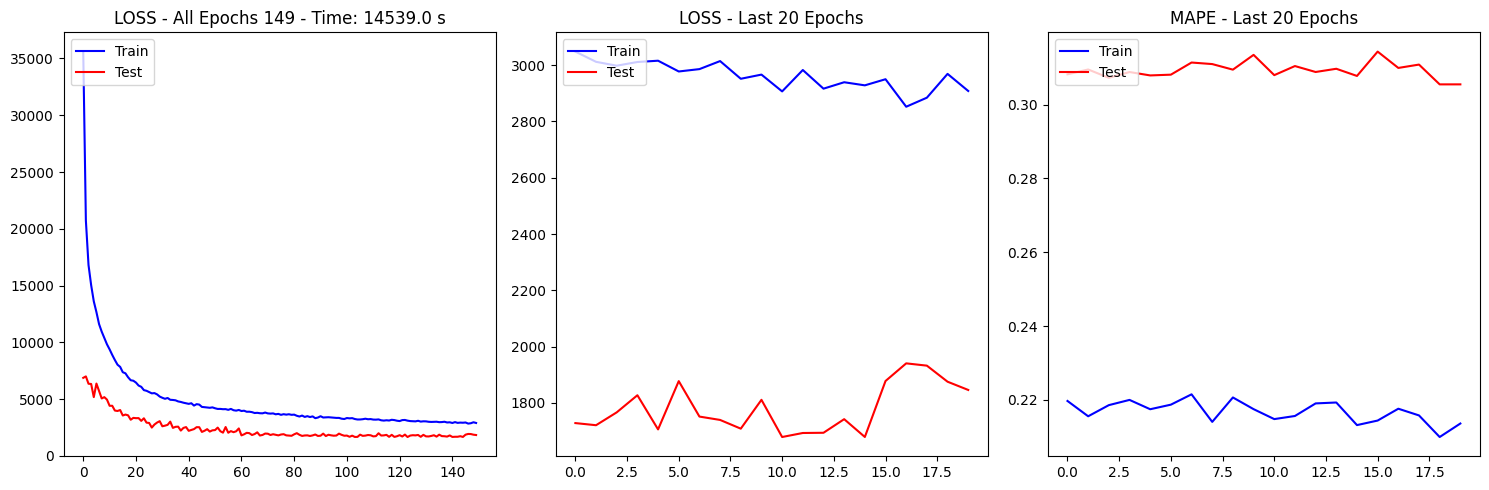

In [41]:
finetune_ds = FineTunningDataset(pems, increment_type='hours', increment=1, steps_ahead=1, step=50)

finetune_loop(get_device(), finetune_ds, gca, 
              #iterations = 1, increment_type='minutes', increment=5,
              iterations = 1, increment_type='hours', increment=1,
              epochs = 150, batch = 1, lr = 0.00001,
              checkpoint_file =  GCA_FILE)

In [42]:
gca_save(GCA_FILE, pems, gca)

In [6]:
#gca.load_state_dict(torch.load(GCA_FILE, weights_only=True))
gca,pems = gca_setup(GCA_FILE,pems, DEVICE)

c:\Users\petro\Dropbox\Projetos\futurelab\posdoc\st_nca\st_nca\st_nca\gca.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_config = torch.load(file)


{'num_heads': 16, 'normalization': <class 'torch.nn.modules.normalization.LayerNorm'>, 'pre_norm': False, 'transformer_feed_forward': 1024, 'transformer_activation': GELU(approximate='none'), 'num_tokens': 10, 'dim_token': 7, 'num_transformers': 3, 'feed_forward': 3, 'feed_forward_dim': 1024, 'feed_forward_activation': GELU(approximate='none'), 'device': 'cuda', 'dtype': torch.float32, 'graph': <networkx.classes.graph.Graph object at 0x00000152110ECCA0>, 'max_length': 10, 'token_size': 7, 'tokenizer': NeighborhoodTokenizer(
  (ztransform): ZTransform()
  (spatial_embedding): SpatialEmbedding()
  (temporal_embedding): TemporalEmbedding()
), 'cell_model': CellModel(
  (transformers): ModuleList(
    (0-2): 3 x Transformer(
      (attention): MultiHeadAttention(
        (sm): Softmax(dim=1)
      )
      (ln1): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
      (flat): Flatten(start_dim=1, end_dim=-1)
      (linear1):

### Evaluation

In [43]:
finetune_ds = FineTunningDataset(pems, increment_type='hour', increment=1, steps_ahead=1, step=250)
df = evaluate(finetune_ds.test(), gca, 1, increment_type='hour', increment=1)
df.describe()

,timestamp,mape,mae,rmse,nrmse
count,13,13.000000,13.000000,13.000000,13.000000
mean,2016-07-01 01:30:00,0.332357,21.699977,32.545645,0.410936
min,2016-07-01 01:00:00,0.282304,15.822866,24.242689,0.312759
25%,2016-07-01 01:15:00,0.296816,18.417435,26.857330,0.351117
50%,2016-07-01 01:30:00,0.328541,19.768103,30.625303,0.408724
75%,2016-07-01 01:45:00,0.359943,25.449953,39.962135,0.478436
max,2016-07-01 02:00:00,0.389053,28.831327,43.601727,0.531728
std,NaN,0.036849,4.468640,7.279795,0.077618


       count       mean        std        min        25%        50%  \
mape  3567.0   0.312515   0.159204   0.103353   0.184381   0.273551   
mae   3567.0  47.731565  20.625093  13.846683  34.806898  42.731842   
rmse  3567.0  62.832427  24.425375  18.441605  47.368361  58.558018   

            75%         max  
mape   0.395114    1.085555  
mae   57.652412  156.718521  
rmse  74.608814  184.596329  


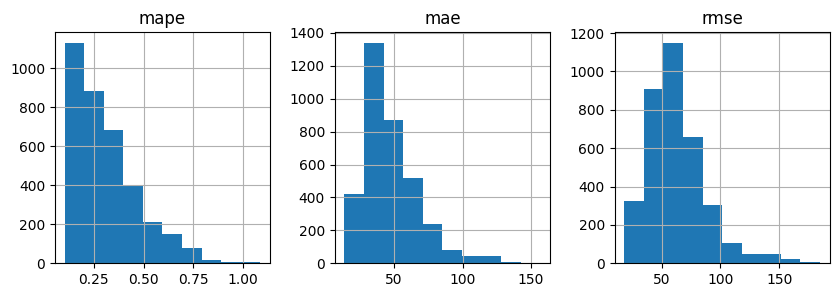

In [54]:
finetune_ds = FineTunningDataset(pems, increment_type='hour', increment=1, steps_ahead=1, step=1)
df = evaluate(finetune_ds.test(), gca, 1, increment_type='hour', increment=1)
print(df[["mape", "mae", "rmse"]].describe().T)
_ = df[["mape", "mae", "rmse"]].hist(figsize=(10, 3), layout=(1,3))

In [60]:
finetune_ds = FineTunningDataset(pems, increment_type='hour', increment=1, steps_ahead=1, step=18)
df = evaluate(finetune_ds.test(), gca, 1, increment_type='hour', increment=1)
df.describe()

,timestamp,mape,mae,rmse,nrmse
count,197,197.000000,197.000000,197.000000,197.000000
mean,2016-07-01 09:10:00,0.206030,33.615533,45.181919,0.210091
min,2016-07-01 01:00:00,0.106615,14.731229,19.455631,0.099164
25%,2016-07-01 05:05:00,0.133380,27.386402,37.253208,0.127203
50%,2016-07-01 09:10:00,0.182162,32.321018,44.145508,0.169250
75%,2016-07-01 13:15:00,0.289692,41.655712,53.415665,0.293329
max,2016-07-01 17:20:00,0.406796,54.631992,72.238930,0.593666
std,NaN,0.084170,9.497278,11.964533,0.105048


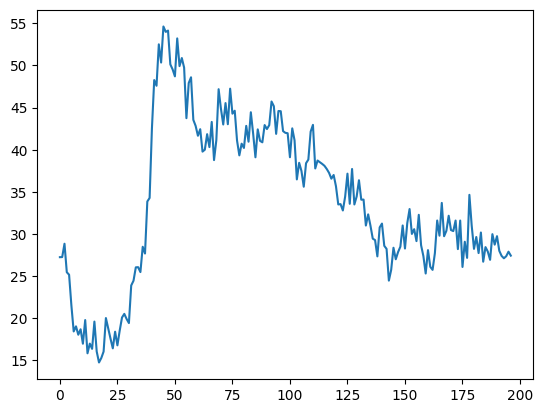

In [61]:
import matplotlib.pyplot as plt

plt.plot(df[["mae"]].values.flatten())

In [62]:

df['weekday'] = df['timestamp'].dt.day_of_week
df['hour'] = df['timestamp'].dt.hour

C:\Users\petro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\petro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


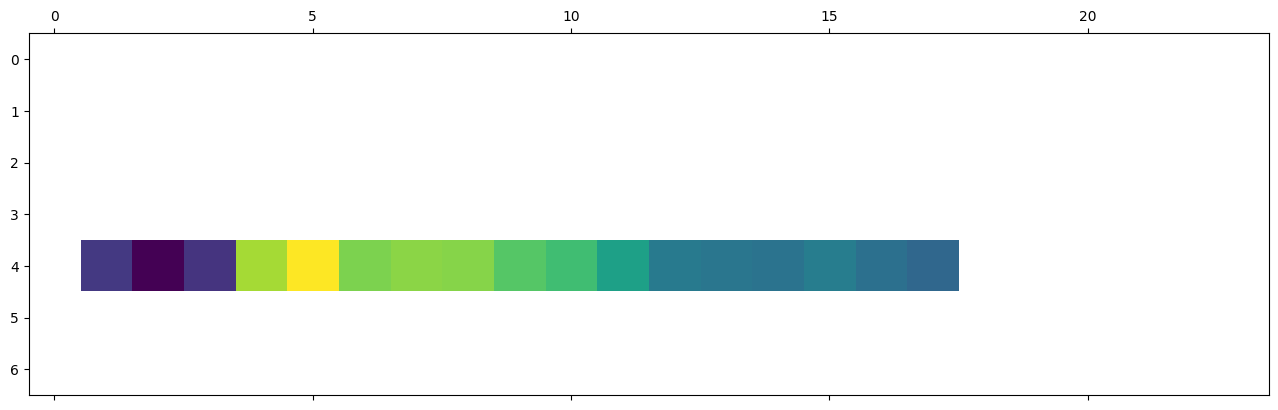

In [63]:
import numpy as np
import pandas as pd
data = []
for day in range(7):
    row = []
    for hour in range(24):
        df2 = df[(df['weekday'] == day) & (df['hour'] == hour)]
        tmp = np.mean(df2['mae'].values)
        row.append(tmp)
    data.append(row)

plt.matshow(data)